In [1]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 1
%aimport mechanics

from sympy import *
from mechanics import *
from mechanics.lagrange import euler_lagrange_equation
import mechanics.space as space

t, = base_spaces('t')
def dot(f): return diff(f, t)

r, = variables('r', t)
theta, = variables(r'\theta', t, space=space.S)
q = r, theta
dq = tuple(dot(q_n) for q_n in q)
ddq = tuple(dot(dq_n) for dq_n in dq)

mu, m = constants(r'\mu, m')

x = r * cos(theta)
y = r * sin(theta)

U = - mu / r
T = (m / 2 * (dot(x)**2 + dot(y)**2)).simplify()
E = T + U
L = T - U
show('L =' , L)


EL = euler_lagrange_equation(L, q)
show_equations(EL)

F = solve(EL, ddq)
show_equations(F)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
%autoreload

from mechanics.integrator.euler import euler_explicit, backward_euler_explicit, heun_explicit
from mechanics.integrator.runge_kutta import rk4_explicit

h, T = constants('h T')
i, = indices('i')

euler_X, euler_step, d = euler_explicit(F, h, i)
print('Euler method:')
show_equations(euler_step)

b_euler_X, b_euler_V, b_euler_step, d = backward_euler_explicit(F, h, i)
print('Backward Euler method:')
show_equations(b_euler_step)

heun_X, heun_K, heun_step, d = heun_explicit(F, h, i)
print('Heun\'s method:')
show_equations(heun_step)

rk4_X, rk4_K, rk4_step, d = rk4_explicit(F, h, i)
print('Runge-Kutta 4:')
show_equations(rk4_step)

r, theta = d(q)
v_r, v_theta = d(dq)


Euler method:


<IPython.core.display.Math object>

Backward Euler method:


<IPython.core.display.Math object>

Heun's method:


<IPython.core.display.Math object>

Runge-Kutta 4:


<IPython.core.display.Math object>

In [3]:
%autoreload

solvers = {}

solver = build_solver()
solver.constants(mu, m, h, T)
solver.variables(*euler_X, index=(i, 0, T/h))
solver.functions('x', 'y', 'E', index=(i, 0, T/h))
solver.inputs(*(x[0] for x in euler_X))
with solver.steps(i, 0, T/h) as step:
    step.explicit(euler_step)
    step.calculate({'x': d(x), 'y': d(y), 'E': d(E)}, i)
solvers['Euler'] = solver.generate()

# solver = build_solver()
# solver.constants(mu, m, h, T)
# solver.variables(*b_euler_X, index=(i, 0, T/h))
# solver.functions('x', 'y', 'E', index=(i, 0, T/h))
# solver.inputs(*(x[0] for x in b_euler_X))
# with solver.steps(i, 0, T/h) as step:
#     step.implicit(b_euler_step, b_euler_V)
#     step.calculate({'x': d(x), 'y': d(y), 'E': d(E)}, i)
# solver.generate()
# solvers['Backward Euler'] = solver

solver = build_solver()
solver.constants(mu, m, h, T)
solver.variables(*heun_X, *heun_K, index=(i, 0, T/h))
solver.functions('x', 'y', 'E', index=(i, 0, T/h))
solver.inputs(*(x[0] for x in heun_X))
with solver.steps(i, 0, T/h) as step:
    step.explicit(heun_step)
    step.calculate({'x': d(x), 'y': d(y), 'E': d(E)}, i)
solvers['Heun'] = solver.generate()

solver = build_solver()
solver.constants(mu, m, h, T)
solver.variables(*rk4_X, *rk4_K, index=(i, 0, T/h))
solver.functions('x', 'y', 'E', index=(i, 0, T/h))
solver.inputs(*(x[0] for x in rk4_X))
with solver.steps(i, 0, T/h) as step:
    step.explicit(rk4_step)
    step.calculate({'x': d(x), 'y': d(y), 'E': d(E)}, i)
solvers['RK4'] = solver.generate()

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpq1emloym/generated.f90
Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpq8lgb5g6/generated.f90
Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp1k9s6_mb/generated.f90


In [4]:
%autoreload
results = {
    name: solver.run({
        mu: 1.0, m: 1.0, 
        h: 0.2, T: 100.0,
        r[0]: 1.0, theta[0]: 0.0,
        v_r[0]: 0.0, v_theta[0]: 1.1,
    }) for name, solver in solvers.items()
}

Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpoxt2f1zc/result.log, size=3511
Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp37b6xnod/result.log, size=5515
Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp1lo4rrwu/result.log, size=9523


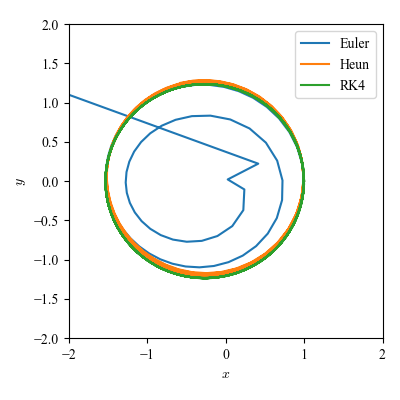

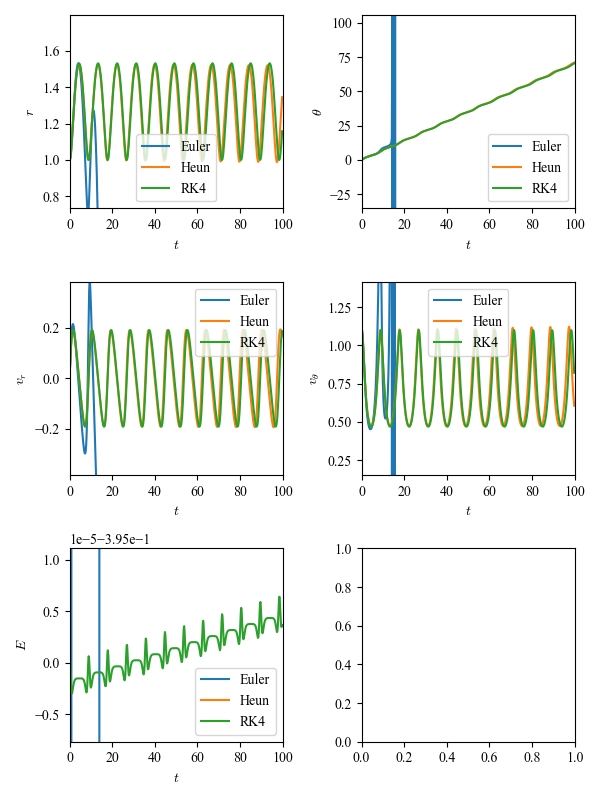

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

t = np.arange(0, results['RK4'][T], results['RK4'][h])

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
for method, _ in results.items():
    ax.plot(_['x'], _['y'], label=method)
ax.legend()

fig, axes = plt.subplots(3, 2, figsize=(6, 8), tight_layout=True)
variables = [r, theta, v_r, v_theta, 'E']
for ax, var in zip(axes.flatten(), variables):
    name = getattr(var, 'name', var)
    ax.set_xlabel('$t$')
    ax.set_ylabel(f'${name}$')
    ax.set_xlim(0, results['RK4'][T])
    value_range = results['RK4'][var][:-1].max() - results['RK4'][var][:-1].min()
    value_center = (results['RK4'][var][:-1].max() + results['RK4'][var][:-1].min()) / 2
    ax.set_ylim(value_center - value_range, value_center + value_range)
    for method, _ in results.items():
        ax.plot(t, _[var][:-1], label=method)
    ax.legend()

